In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pickle
from helper_functions import calibration_curves
sns.set_theme(
    context="talk",
    style="ticks",
    rc={"font.sans-serif": "Fira Sans Condensed"},
)
figure_folder = "../../reports/figures"

In [26]:
eval_datasets = ["mnist", "svhn"]

types = [
    "ensemble_5",
    "ensemble_10",
    "multiswag_5",
    "multiswag_10",
    "radial",
    "meanfield",
    "lowrank",
    "laplace",
    "ml",
    "map",
]

results = pd.DataFrame()
for dataset in eval_datasets:

    df = []
    for type in types:
        with open(f"../../results/{type}.pkl", "rb") as f:
            data = pickle.load(f)[f"eval_{dataset}"]
            df.append(data)
    df = pd.DataFrame.from_dict(df)
    df.insert(0, "Type", types)
    results = pd.concat([results, df])

results = results.rename(columns={
    "Average confidence": "Avg. Conf.",
    "Average confidence when wrong": "Avg. Conf. -",
    "Average confidence when right": "Avg. Conf. +",
})

# Ensembles

,Type,Evaluated on,NLL,Accuracy,AUROC,Avg. Conf.,Avg. Conf. -,Avg. Conf. +,ECE
0,ensemble_5,mnist,-0.967706,0.98250,0.999596,0.975321,0.634342,0.981395,0.012623
1,ensemble_10,mnist,-0.968230,0.98420,0.999698,0.974864,0.632465,0.980361,0.012827
0,ensemble_5,svhn,-0.156320,0.16714,0.539306,0.568379,0.555841,0.630854,0.400102
1,ensemble_10,svhn,-0.145252,0.15285,0.537315,0.560981,0.549999,0.621852,0.408004


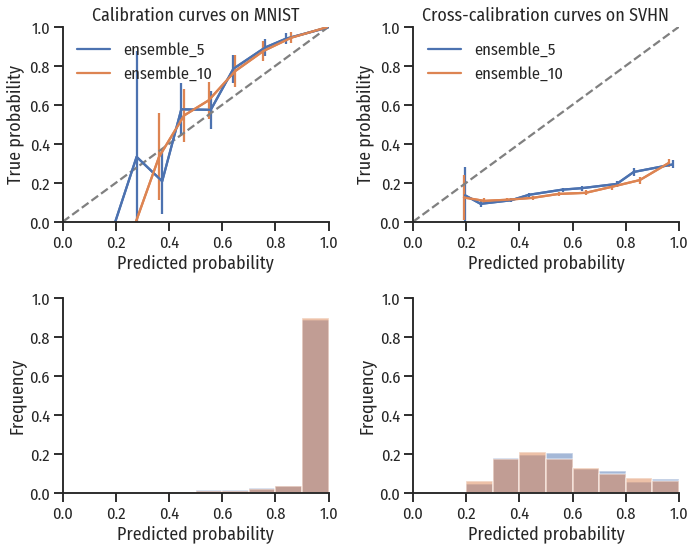

In [27]:
bins = 10

eval_datasets = ["mnist", "svhn"]
titles = ["Calibration curves on MNIST", "Cross-calibration curves on SVHN"]

types = [
    "ensemble_5",
    "ensemble_10",
]

fig, ax = plt.subplots(ncols=len(eval_datasets), nrows=2, figsize=(10,8))
for i, (dataset, title) in enumerate(zip(eval_datasets, titles)):
    for type in types:
        criteria = f"`Evaluated on` == '{dataset}' and Type == '{type}'"
        data = results.query(criteria)
        
        targets = data["Test targets"].values[0][:,None]
        probs = data["Test probabilities"].values[0]
        confidences = np.max(probs, axis=1)

        ece, prob_true, prob_pred, n_in_bins = calibration_curves(targets, probs, bins=bins)
        error = 2*np.sqrt( (prob_true * (1-prob_true)) / n_in_bins[n_in_bins > 0] )
        results.loc[results.eval(criteria), 'ECE'] = ece
    
        line, = ax[0, i].plot(prob_pred, prob_true, label=f"{type}")
        ax[0, i].errorbar(x=prob_pred, y=prob_true, yerr=error, c=line.get_color())

        ax[1, i].bar(np.linspace(0, 1, bins+1)[-bins:]-1/(2*bins), n_in_bins / np.sum(n_in_bins), width=1/bins, color=line.get_color(), alpha=0.5)

    ls = np.linspace(0, 1)
    ax[0, i].plot(ls, ls, "--", color="grey")
    ax[0, i].set(
        xlabel="Predicted probability",
        ylabel="True probability",
        title=title,
        xlim=(0, 1),
        ylim=(0, 1),
    )
    ax[0, i].legend(frameon=False)

    ax[1, i].set(
        xlabel="Predicted probability",
        ylabel="Frequency",
        xlim=(0, 1),
        ylim=(0, 1),
    )

fig.tight_layout()
sns.despine(fig)

fig.savefig(f"{figure_folder}/MnistEnsembles.pdf")

results.query("`Evaluated on` in @eval_datasets and `Type` in @types").drop(["Test targets", "Test probabilities"], axis=1)

# Guides

,Type,Evaluated on,NLL,Accuracy,AUROC,Avg. Conf.,Avg. Conf. -,Avg. Conf. +,ECE
4,radial,mnist,0.118390,0.964400,0.998985,0.952825,0.644966,0.964189,0.014132
5,meanfield,mnist,0.253454,0.932200,0.995878,0.880027,0.564733,0.902958,0.052173
7,laplace,mnist,0.300168,0.916900,0.994094,0.865457,0.570010,0.892234,0.051491
4,radial,svhn,5.554090,0.149278,0.519426,0.688402,0.680008,0.736236,0.539124
5,meanfield,svhn,4.618915,0.143016,0.501530,0.574549,0.569842,0.602751,0.431532
7,laplace,svhn,5.570078,0.117394,0.510722,0.629852,0.631551,0.617079,0.512458


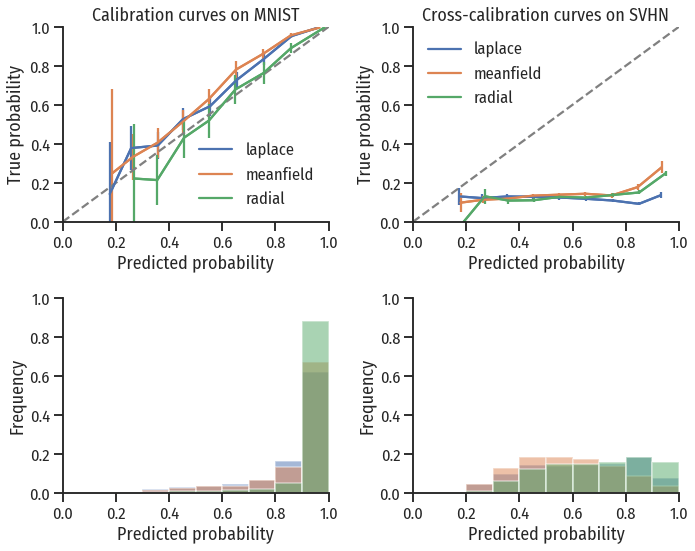

In [29]:
bins = 10

eval_datasets = ["mnist", "svhn"]
titles = ["Calibration curves on MNIST", "Cross-calibration curves on SVHN"]
types = [
    # "ml",
    # "map",
    "laplace",
    "meanfield",
    "radial",
    # "lowrank",
]


fig, ax = plt.subplots(ncols=len(eval_datasets), nrows=2, figsize=(10,8))
for i, (dataset, title) in enumerate(zip(eval_datasets, titles)):
    for type in types:
        criteria = f"`Evaluated on` == '{dataset}' and Type == '{type}'"
        data = results.query(criteria)
        
        targets = data["Test targets"].values[0][:,None]
        probs = data["Test probabilities"].values[0]
        confidences = np.max(probs, axis=1)

        ece, prob_true, prob_pred, n_in_bins = calibration_curves(targets, probs, bins=bins)
        error = 2*np.sqrt( (prob_true * (1-prob_true)) / n_in_bins[n_in_bins > 0] )
        results.loc[results.eval(criteria), 'ECE'] = ece
    
        line, = ax[0, i].plot(prob_pred, prob_true, label=f"{type}")
        ax[0, i].errorbar(x=prob_pred, y=prob_true, yerr=error, c=line.get_color())

        ax[1, i].bar(np.linspace(0, 1, bins+1)[-bins:]-1/(2*bins), n_in_bins / np.sum(n_in_bins), width=1/bins, color=line.get_color(), alpha=0.5)

    ls = np.linspace(0, 1)
    ax[0, i].plot(ls, ls, "--", color="grey")
    ax[0, i].set(
        xlabel="Predicted probability",
        ylabel="True probability",
        title=title,
        xlim=(0, 1),
        ylim=(0, 1),
    )
    ax[0, i].legend(frameon=False)

    ax[1, i].set(
        xlabel="Predicted probability",
        ylabel="Frequency",
        xlim=(0, 1),
        ylim=(0, 1),
    )

fig.tight_layout()
sns.despine(fig)

fig.savefig(f"{figure_folder}/MnistVI.pdf")

results.query("`Evaluated on` in @eval_datasets and `Type` in @types").drop(["Test targets", "Test probabilities"], axis=1)

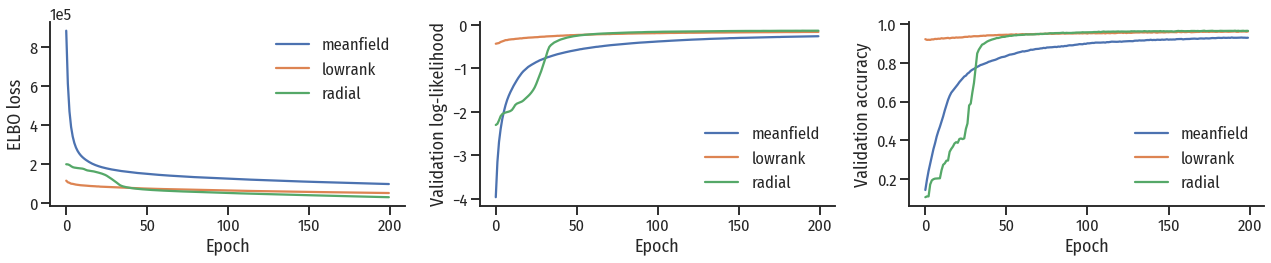

In [30]:
fig, ax = plt.subplots(ncols=3, figsize=(18,4))
for guide in [
    "meanfield",
    "lowrank",
    "radial",
]:
    with open(f"../../results/{guide}.pkl", "rb") as f:
        data = pickle.load(f)
        epochs = np.arange(len(data["Training ELBO"]))
        sns.lineplot(x=epochs, y=data["Training ELBO"].squeeze(), label=guide, ax=ax[0])
        sns.lineplot(x=epochs, y=data["Validation log-likelihood"].squeeze(), label=guide, ax=ax[1])
        sns.lineplot(x=epochs, y=data["Validation accuracy"].squeeze(), label=guide, ax=ax[2])
ax[0].set(
    xlabel="Epoch",
    ylabel="ELBO loss",
)
ax[1].set(
    xlabel="Epoch",
    ylabel="Validation log-likelihood",
)
ax[2].set(
    xlabel="Epoch",
    ylabel="Validation accuracy",
)
ax[0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax[0].legend(frameon=False)
ax[1].legend(frameon=False)
ax[2].legend(frameon=False)

fig.tight_layout()
sns.despine(fig)

# MultiSWAG

,Type,Evaluated on,NLL,Accuracy,AUROC,Avg. Conf.,Avg. Conf. -,Avg. Conf. +,ECE
2,multiswag_5,mnist,-0.976133,0.983100,0.999766,0.983704,0.668649,0.989120,0.006224
3,multiswag_10,mnist,-0.976707,0.984000,0.999800,0.983951,0.669031,0.989071,0.005069
2,multiswag_5,svhn,-0.149697,0.152274,0.534170,0.637637,0.627323,0.695058,0.485182
3,multiswag_10,svhn,-0.148872,0.153657,0.537753,0.613196,0.601627,0.676922,0.459393


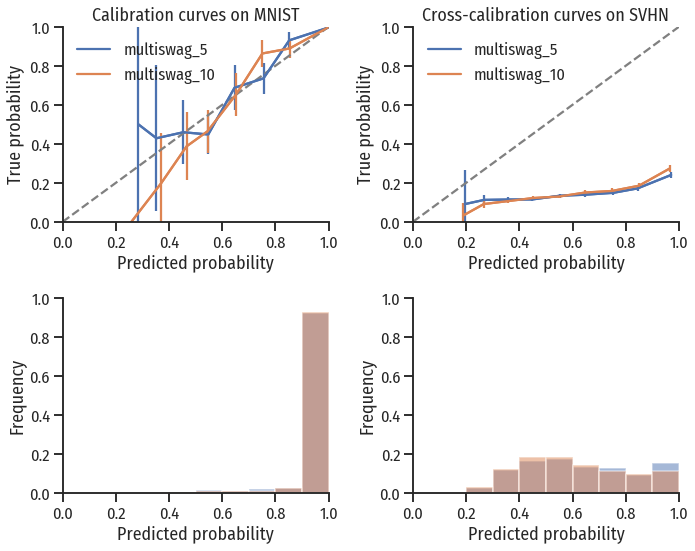

In [31]:
bins = 10

eval_datasets = ["mnist", "svhn"]
titles = ["Calibration curves on MNIST", "Cross-calibration curves on SVHN"]

types = [
    "multiswag_5",
    "multiswag_10",
]

fig, ax = plt.subplots(ncols=len(eval_datasets), nrows=2, figsize=(10,8))
for i, (dataset, title) in enumerate(zip(eval_datasets, titles)):
    for type in types:
        criteria = f"`Evaluated on` == '{dataset}' and Type == '{type}'"
        data = results.query(criteria)
        
        targets = data["Test targets"].values[0][:,None]
        probs = data["Test probabilities"].values[0]
        confidences = np.max(probs, axis=1)

        ece, prob_true, prob_pred, n_in_bins = calibration_curves(targets, probs, bins=bins)
        error = 2*np.sqrt( (prob_true * (1-prob_true)) / n_in_bins[n_in_bins > 0] )
        results.loc[results.eval(criteria), 'ECE'] = ece
    
        line, = ax[0, i].plot(prob_pred, prob_true, label=f"{type}")
        ax[0, i].errorbar(x=prob_pred, y=prob_true, yerr=error, c=line.get_color())

        ax[1, i].bar(np.linspace(0, 1, bins+1)[-bins:]-1/(2*bins), n_in_bins / np.sum(n_in_bins), width=1/bins, color=line.get_color(), alpha=0.5)

    ls = np.linspace(0, 1)
    ax[0, i].plot(ls, ls, "--", color="grey")
    ax[0, i].set(
        xlabel="Predicted probability",
        ylabel="True probability",
        title=title,
        xlim=(0, 1),
        ylim=(0, 1),
    )
    ax[0, i].legend(frameon=False)

    ax[1, i].set(
        xlabel="Predicted probability",
        ylabel="Frequency",
        xlim=(0, 1),
        ylim=(0, 1),
    )

fig.tight_layout()
sns.despine(fig)

fig.savefig(f"{figure_folder}/MnistMultiSwag.pdf")

results.query("`Evaluated on` in @eval_datasets and `Type` in @types").drop(["Test targets", "Test probabilities"], axis=1)

In [32]:
results\
    .query("`Evaluated on` == 'mnist'")\
    .drop(["Test targets", "Test probabilities"], axis=1)

,Type,Evaluated on,NLL,Accuracy,AUROC,Avg. Conf.,Avg. Conf. -,Avg. Conf. +,ECE
0,ensemble_5,mnist,-0.967706,0.9825,0.999596,0.975321,0.634342,0.981395,0.012623
1,ensemble_10,mnist,-0.968230,0.9842,0.999698,0.974864,0.632465,0.980361,0.012827
2,multiswag_5,mnist,-0.976133,0.9831,0.999766,0.983704,0.668649,0.989120,0.006224
3,multiswag_10,mnist,-0.976707,0.9840,0.999800,0.983951,0.669031,0.989071,0.005069
4,radial,mnist,0.118390,0.9644,0.998985,0.952825,0.644966,0.964189,0.014132
5,meanfield,mnist,0.253454,0.9322,0.995878,0.880027,0.564733,0.902958,0.052173
6,lowrank,mnist,0.163274,0.9588,0.998595,0.913616,0.549929,0.929244,0.045184
7,laplace,mnist,0.300168,0.9169,0.994094,0.865457,0.570010,0.892234,0.051491
8,ml,mnist,0.114467,0.9678,0.999114,0.948653,0.647871,0.958660,0.019147
9,map,mnist,0.334367,0.9115,0.992319,0.849485,0.581839,0.875472,0.063345


In [33]:
results\
    .query("`Evaluated on` == 'svhn'")\
    .drop(["Test targets", "Test probabilities"], axis=1)

,Type,Evaluated on,NLL,Accuracy,AUROC,Avg. Conf.,Avg. Conf. -,Avg. Conf. +,ECE
0,ensemble_5,svhn,-0.156320,0.167140,0.539306,0.568379,0.555841,0.630854,0.400102
1,ensemble_10,svhn,-0.145252,0.152850,0.537315,0.560981,0.549999,0.621852,0.408004
2,multiswag_5,svhn,-0.149697,0.152274,0.534170,0.637637,0.627323,0.695058,0.485182
3,multiswag_10,svhn,-0.148872,0.153657,0.537753,0.613196,0.601627,0.676922,0.459393
4,radial,svhn,5.554090,0.149278,0.519426,0.688402,0.680008,0.736236,0.539124
5,meanfield,svhn,4.618915,0.143016,0.501530,0.574549,0.569842,0.602751,0.431532
6,lowrank,svhn,3.079485,0.125615,0.552135,0.484786,0.474131,0.558949,0.359171
7,laplace,svhn,5.570078,0.117394,0.510722,0.629852,0.631551,0.617079,0.512458
8,ml,svhn,5.175025,0.128765,0.514042,0.648371,0.640120,0.704200,0.519607
9,map,svhn,5.666493,0.132952,0.525037,0.585058,0.581270,0.609763,0.452106


In [34]:
print(
results\
    .drop(["Test targets", "Test probabilities"], axis=1)\
    .to_latex(index=False, float_format="%.4f")
)

\begin{tabular}{llrrrrrrr}
\toprule
        Type & Evaluated on &     NLL &  Accuracy &  AUROC &  Avg. Conf. &  Avg. Conf. - &  Avg. Conf. + &    ECE \\
\midrule
  ensemble\_5 &        mnist & -0.9677 &    0.9825 & 0.9996 &      0.9753 &        0.6343 &        0.9814 & 0.0126 \\
 ensemble\_10 &        mnist & -0.9682 &    0.9842 & 0.9997 &      0.9749 &        0.6325 &        0.9804 & 0.0128 \\
 multiswag\_5 &        mnist & -0.9761 &    0.9831 & 0.9998 &      0.9837 &        0.6686 &        0.9891 & 0.0062 \\
multiswag\_10 &        mnist & -0.9767 &    0.9840 & 0.9998 &      0.9840 &        0.6690 &        0.9891 & 0.0051 \\
      radial &        mnist &  0.1184 &    0.9644 & 0.9990 &      0.9528 &        0.6450 &        0.9642 & 0.0141 \\
   meanfield &        mnist &  0.2535 &    0.9322 & 0.9959 &      0.8800 &        0.5647 &        0.9030 & 0.0522 \\
     lowrank &        mnist &  0.1633 &    0.9588 & 0.9986 &      0.9136 &        0.5499 &        0.9292 & 0.0452 \\
     laplace & 

/tmp/ipykernel_237/1935804555.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  results\
